In [1]:
from astropy.io import fits
import numpy as np
from photutils import CircularAperture
from photutils import aperture_photometry
from astropy.table import Table

In [2]:
biasfiles = [line.rstrip('\n') for line in open('bias.list')]

In [3]:
biasfiles

['Wolf1346/bias.0006.fits',
 'Wolf1346/bias.0007.fits',
 'Wolf1346/bias.0008.fits',
 'Wolf1346/bias.0009.fits',
 'Wolf1346/bias.0010.fits',
 'Wolf1346/bias.0011.fits',
 'Wolf1346/bias.0012.fits',
 'Wolf1346/bias.0013.fits',
 'Wolf1346/bias.0014.fits',
 'Wolf1346/bias.0015.fits',
 'Wolf1346/bias.0016.fits']

### Geting the master bias

In [4]:
data = []
for file in biasfiles:
    data.append(fits.getdata(file))

In [5]:
avgBias = np.median(data, axis=0)

In [6]:
header = fits.getheader(biasfiles[0])

In [7]:
header['HISTORY'] = 'Median combined'
fits.writeto('Wolf1346/bias.fits', avgBias, header, overwrite=True)

### Subtracting the bias

In [8]:
!ls Wolf1346/flat.00??.fits > before.list

In [9]:
!ls Wolf1346/wolf1346_.000?.fits >> before.list

In [10]:
!ls Wolf1346/wolf1346_m.0001.fits >> before.list

In [11]:
datafilesin = [line.rstrip('\n') for line in open('before.list')]
datafilesout = [line.rstrip('\n') for line in open('refined.list')]
# print(datafilesout)
n = len(datafilesin)
for i in np.arange(n):
    data, header = fits.getdata(datafilesin[i], header=True)
    dataout = data - avgBias
#     header['HISTORY'] = 'Bias subtracted'
#     print(type(fits))
    fits.writeto(datafilesout[i], dataout, overwrite=True)

### Overscan removal

In [12]:
data = fits.getdata("Wolf1346/flat.0005r.fits")

In [13]:
data.max()

45393.0

In [14]:
data.min()

-65046.0

In [15]:
np.shape([[1,2],[3,5],[4,5]])

(3, 2)

In [16]:
np.shape(data[:,1027:1077])

(2050, 50)

In [17]:
overscan_removed1 = np.delete(data, np.s_[1026:1078], axis=1)

In [18]:
overscan_removed2 = np.delete(overscan_removed1, np.s_[1024:1028], axis=0)

In [19]:
print(np.shape(overscan_removed1), np.shape(overscan_removed2))

(2050, 2050) (2046, 2050)


In [20]:
fits.writeto('Wolf1346/flat.0005d.fits', overscan_removed2, overwrite=True)

In [21]:
readin = [line.rstrip('\n') for line in open('refined.list')]
readout = [line.rstrip('\n') for line in open('overscan.list')]
n = len(readin)

In [22]:
for i in np.arange(n):
    data = fits.getdata(readin[i])
    data1 = np.delete(data, np.s_[1026:1078], axis=1)
    data2 = np.delete(data1, np.s_[1024:1028], axis=0)
    fits.writeto(readout[i], data2, overwrite=True)

In [23]:
datalist = [line.rstrip('\n') for line in open('before.list')]
n = len(datalist)
filter_list = []
for i in np.arange(n):
    data, header = fits.getdata(datalist[i], header=True)
    filter_list.append(header['FILTER'])

In [24]:
filter_table = Table(names=['Flat file', 'Filter'], data=[datalist[:-4], filter_list[:-4]])

print(filter_table[0:20])
print(filter_table[20:])

       Flat file        Filter
----------------------- ------
Wolf1346/flat.0005.fits Wash M
Wolf1346/flat.0006.fits Wash M
Wolf1346/flat.0007.fits Wash M
Wolf1346/flat.0008.fits Wash M
Wolf1346/flat.0009.fits Wash M
Wolf1346/flat.0010.fits Wash M
Wolf1346/flat.0011.fits Wash M
Wolf1346/flat.0012.fits Wash M
Wolf1346/flat.0013.fits Wash M
Wolf1346/flat.0014.fits Wash M
Wolf1346/flat.0015.fits Wash M
Wolf1346/flat.0016.fits Wash M
Wolf1346/flat.0017.fits J-C Rc
Wolf1346/flat.0018.fits J-C Rc
Wolf1346/flat.0019.fits J-C Rc
Wolf1346/flat.0020.fits J-C Rc
Wolf1346/flat.0021.fits J-C Rc
Wolf1346/flat.0022.fits J-C Rc
Wolf1346/flat.0023.fits J-C Rc
Wolf1346/flat.0024.fits J-C Rc
       Flat file        Filter
----------------------- ------
Wolf1346/flat.0025.fits J-C Rc
Wolf1346/flat.0026.fits J-C Rc
Wolf1346/flat.0027.fits J-C Rc
Wolf1346/flat.0028.fits J-C Rc
Wolf1346/flat.0029.fits J-C Rc
Wolf1346/flat.0030.fits J-C Rc
Wolf1346/flat.0031.fits J-C Rc
Wolf1346/flat.0032.fits J-C Rc
Wolf1346

*-------------------

# Data Reduction (Photometry)

In [25]:
from astropy.io import fits
import numpy as np
from photutils import CircularAperture
from photutils import aperture_photometry
from photutils.aperture import CircularAnnulus
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize
%matplotlib inline

In [26]:
positions1 = [(183, 1570), (1464, 1690), (1018, 959), (502, 570),
            (1284, 827), (1590, 1023), (1601, 249), (1461, 487), (738, 201),
            (1089, 582)]
apertures1 = CircularAperture(positions1, r=20)
apertures2 = CircularAperture(positions1, r=10)
apertures3 = CircularAperture(positions1, r=40)

In [27]:
print(apertures1)

Aperture: CircularAperture
positions: [[ 183, 1570],
            [1464, 1690],
            [1018,  959],
            [ 502,  570],
            [1284,  827],
            [1590, 1023],
            [1601,  249],
            [1461,  487],
            [ 738,  201],
            [1089,  582]]
r: 20.0


In [28]:
image = fits.getdata("Wolf1346/wolf1346_.0001d.fits")
center_method = aperture_photometry(image, apertures1, method='center')

In [29]:
# changes the method on how we are calculating the aperture_sum
center = aperture_photometry(image, apertures1, method='center')
subpixel = aperture_photometry(image, apertures1, method='subpixel')
exact = aperture_photometry(image, apertures1)

# print(center)

In [30]:
print(center_method)

 id xcenter ycenter aperture_sum
      pix     pix               
--- ------- ------- ------------
  1   183.0  1570.0    3074907.0
  2  1464.0  1690.0    7635786.0
  3  1018.0   959.0    3555702.0
  4   502.0   570.0    1316396.0
  5  1284.0   827.0    2956652.0
  6  1590.0  1023.0    9603892.0
  7  1601.0   249.0    1696293.0
  8  1461.0   487.0    2610581.0
  9   738.0   201.0    1506073.0
 10  1089.0   582.0     530931.0


In [31]:
annuli = CircularAnnulus(positions1, r_in=35, r_out=45)

In [32]:
center_annulus = aperture_photometry(image, annuli, method='center')
print(center_annulus)

 id xcenter ycenter aperture_sum
      pix     pix               
--- ------- ------- ------------
  1   183.0  1570.0     709855.0
  2  1464.0  1690.0     792817.0
  3  1018.0   959.0     769566.0
  4   502.0   570.0     781374.0
  5  1284.0   827.0     792917.0
  6  1590.0  1023.0     867961.0
  7  1601.0   249.0     713226.0
  8  1461.0   487.0     754663.0
  9   738.0   201.0     718681.0
 10  1089.0   582.0     746865.0


In [33]:
# calculating the background
bkg_mean = center_annulus['aperture_sum'] / annuli.area()
bkg_sum = bkg_mean * apertures1.area()
final_sum = center['aperture_sum'] - bkg_sum
center['residual_aperture_sum'] = final_sum
# print(annuli.area())
print(bkg_sum)
print(center['residual_aperture_sum'])

aperture_sum
------------
    354927.5
    396408.5
    384783.0
    390687.0
    396458.5
    433980.5
    356613.0
    377331.5
    359340.5
    373432.5
residual_aperture_sum
---------------------
            2719979.5
            7239377.5
            3170919.0
             925709.0
            2560193.5
            9169911.5
            1339680.0
            2233249.5
            1146732.5
             157498.5


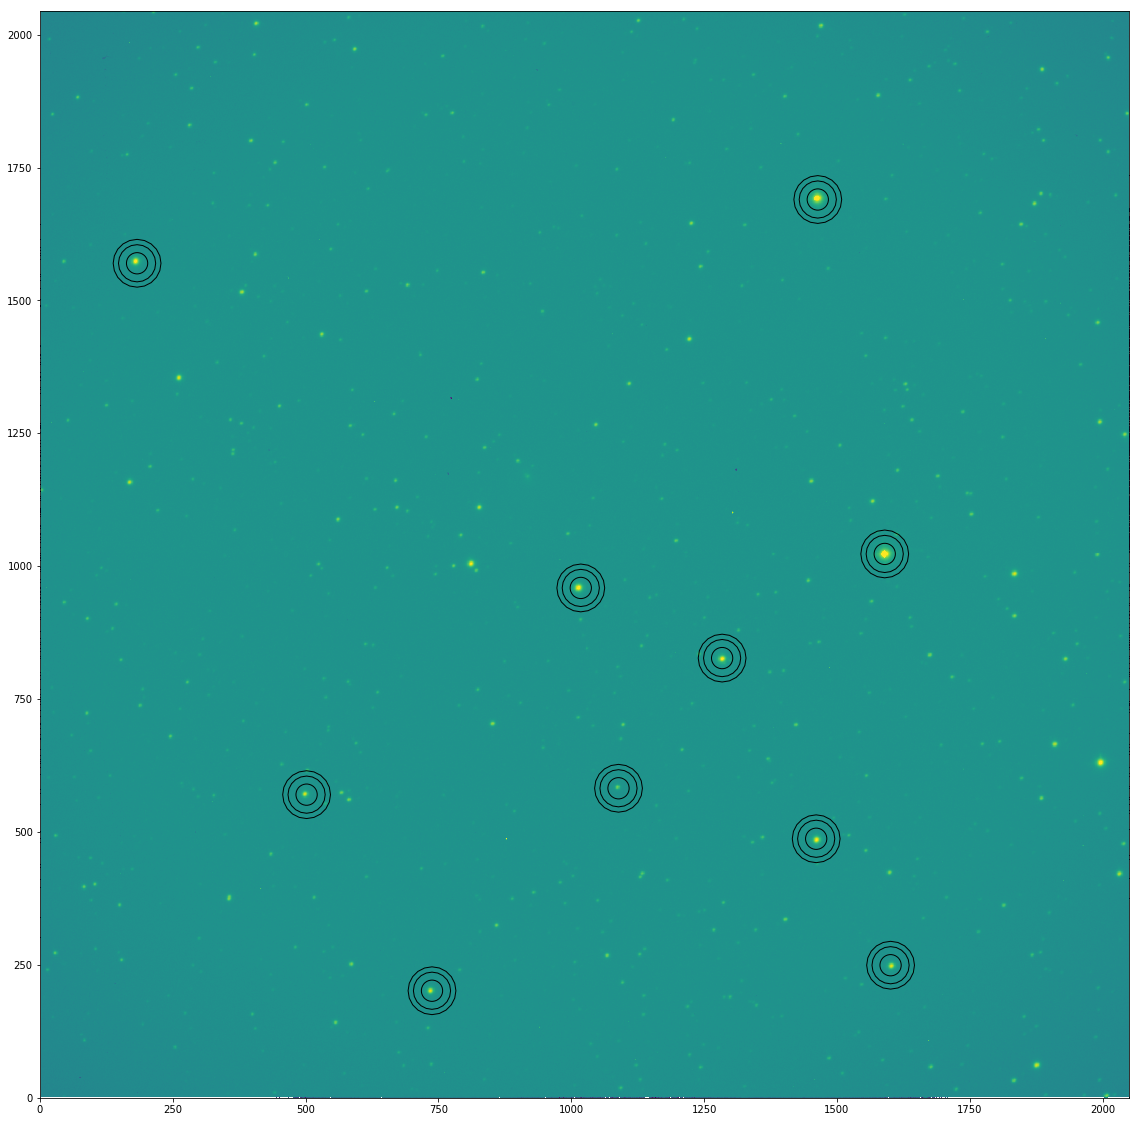

In [34]:
plt.figure(figsize=(20, 20))
plt.imshow(image, norm=LogNorm())
plt.gca().invert_yaxis()
apertures1.plot()
annuli.plot()

In [35]:
# comparing the different methods
avg_count = []
methods = ['center', 'subpixel']
radii = np.linspace(10, 30, 20)
for i_method in methods:
    avg_count_radii = []
    for i_radius in radii:
        aperture = CircularAperture(positions1, r=i_radius)
        annulus = CircularAnnulus(positions1, r_in=(i_radius+6), r_out=(i_radius+12))
        center = aperture_photometry(image, aperture, method=i_method)
        center_annulus = aperture_photometry(image, annulus, method=i_method)
        bkg_mean = center_annulus['aperture_sum'] / annulus.area()
        bkg_sum = bkg_mean * aperture.area()
        final_sum = center['aperture_sum'] - bkg_sum
        center['residual_aperture_sum'] = final_sum
        avg_count_radii.append((final_sum / apertures1.area())[1])
    avg_count.append(avg_count_radii)
    
# print(avg_count)

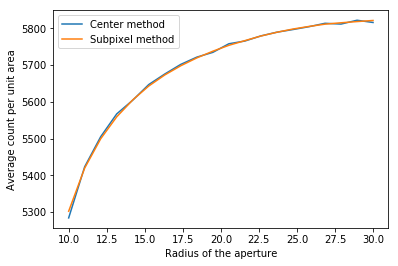

In [36]:
plt.plot(radii, avg_count[0], label='Center method')
plt.plot(radii, avg_count[1], label='Subpixel method')
plt.ylabel('Average count per unit area')
plt.xlabel('Radius of the aperture')
plt.legend(loc=2);

*---

### PSF photometry

In [37]:
from photutils import detection
from photutils import background

from astropy.stats import sigma_clipped_stats
from photutils import datasets

from photutils import DAOStarFinder
from photutils import make_source_mask

from astropy.stats import SigmaClip
from photutils import Background2D, MedianBackground

In [38]:
data = fits.getdata('Wolf1346/wolf1346_.0001d.fits')
mean, median, std = sigma_clipped_stats(data, sigma=10.0, iters=5)

In [39]:
daofind = DAOStarFinder(fwhm=3.0, threshold=10*std)
sources = daofind(data - median)

sources

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,2005.6059842079358,3.786849536958602,0.43115268544867796,0.6784194351395784,-0.3176161320051251,25.0,0.0,6696.0,9.13583736062423,-2.4018708987703707
2,1722.4481312569417,16.069485877170138,0.41237661116645885,0.5021550796853503,-0.18211945997676962,25.0,0.0,999.0,1.3066477398491712,-0.2903963039562025
3,1091.6518786923907,18.341621171394614,0.4847690381698391,0.3976024253042056,-0.22078697509208817,25.0,0.0,1514.0,1.9964284303689164,-0.7506343646467313
4,1831.288296727341,32.553469712294365,0.41283722904915354,0.5707792877565787,-0.24114192022444256,25.0,0.0,3886.0,5.1374401843183755,-1.7768669459588835
5,1455.5694629441086,33.52125791381089,0.6762921570800835,0.3762458799612066,0.003328323631628457,25.0,0.0,678.0,1.8643037984389121,-0.676291711079027
6,1241.931758072072,57.50680555227487,0.4636751544268808,0.3601238185669595,-0.20705380320705866,25.0,0.0,1201.0,1.6040842850270824,-0.5130679603075156
7,1674.9609731693329,58.15765484824333,0.43806896062628714,0.46843688764982055,-0.2826317807002476,25.0,0.0,3308.0,4.345748092747821,-1.5951613705961427
8,1874.0565409894302,61.109746827215545,0.4266624548392053,0.48814157469167596,-0.35058180470507266,25.0,0.0,26185.0,33.64997263284422,-3.817461788382933
9,735.5311435566133,63.220014025702056,0.36373207339659797,0.23908909434586495,-0.013871875547341346,25.0,0.0,873.0,1.202148286979535,-0.1998951047842107


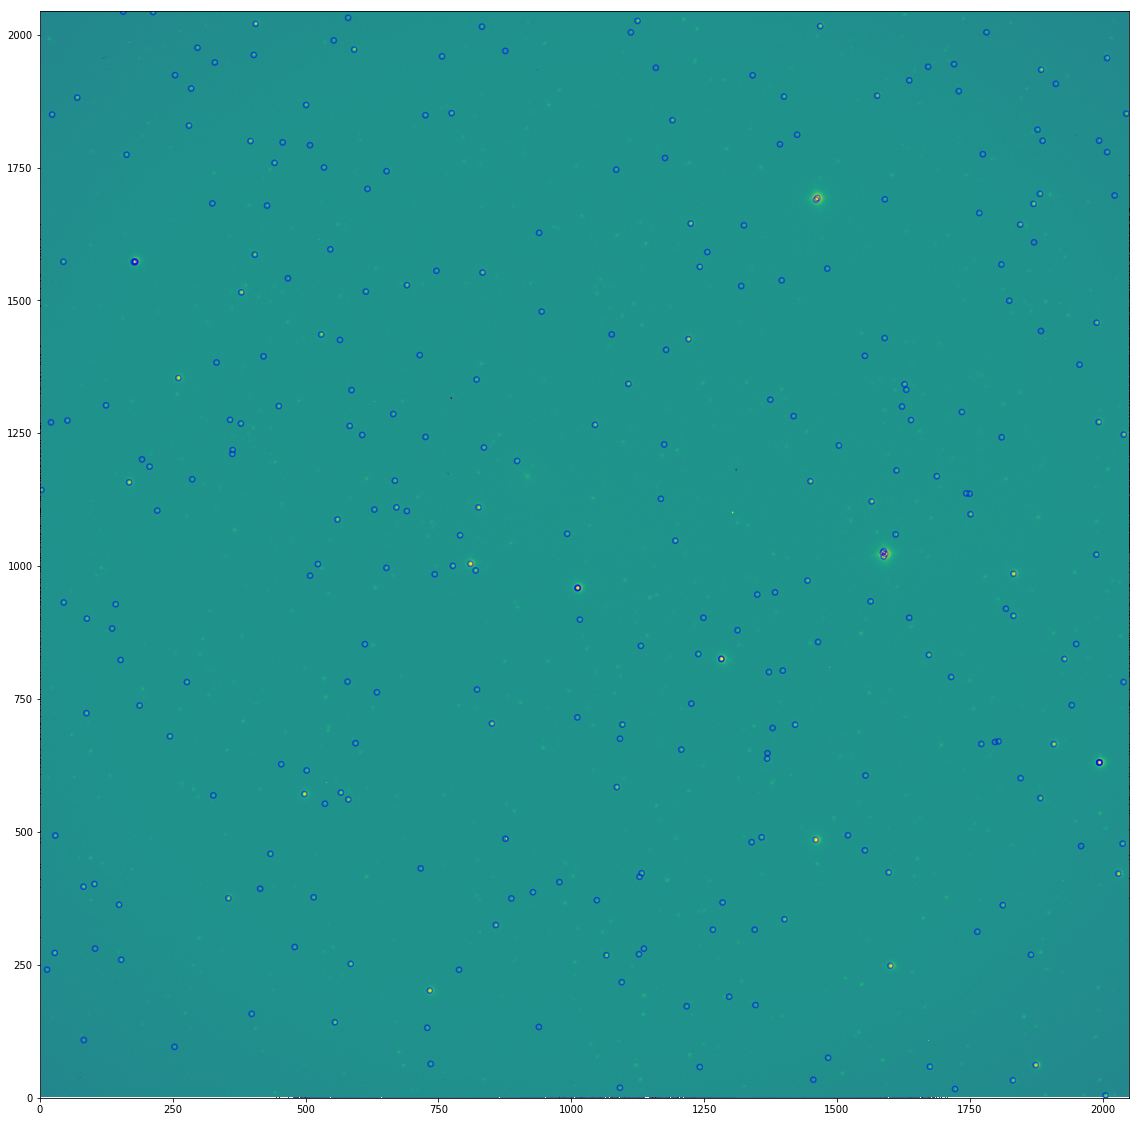

In [40]:
import matplotlib.pyplot as plt
from photutils import CircularAperture
positions = (sources['xcentroid'], sources['ycentroid'])
psf_apertures = CircularAperture(positions, r=5.)
plt.figure(figsize=(20, 20))
plt.imshow(data, origin='lower', norm=LogNorm())
psf_apertures.plot(color='blue', lw=1.5, alpha=0.5)

In [41]:
sigma_clip = SigmaClip(sigma=10., iters=5)
bkg_estimator = MedianBackground()
bkg = Background2D(data, (50, 50), filter_size=(3, 3),
                    sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

Background calculated through Background2D command, and the subtracted value shown below.

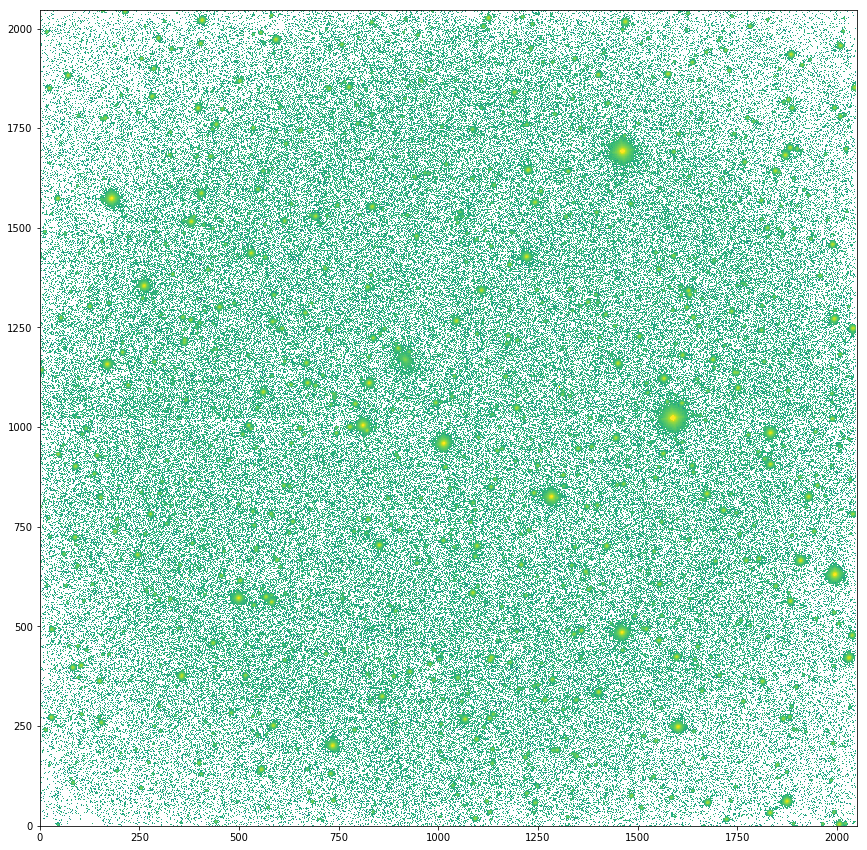

In [42]:
plt.figure(figsize=(15, 15))
plt.imshow(data - bkg.background, origin='lower', norm=LogNorm())

*---

In [43]:
from photutils.psf import IterativelySubtractedPSFPhotometry
from photutils.psf import IntegratedGaussianPRF, DAOGroup
from astropy.stats import gaussian_sigma_to_fwhm
from astropy.modeling.fitting import LevMarLSQFitter
from photutils.background import MMMBackground, MADStdBackgroundRMS
from photutils.detection import IRAFStarFinder
from photutils.psf import BasicPSFPhotometry

In [44]:
image = fits.getdata('Wolf1346/wolf1346_.0001d.fits')

# sigma_psf = 10
# daogroup = DAOGroup(2.0*sigma_psf*gaussian_sigma_to_fwhm)
# psf_model = IntegratedGaussianPRF(sigma=sigma_psf)
# mmm_bkg = MMMBackground

# my_photometry = IterativelySubtractedPSFPhotometry(
#      finder=daofind, group_maker=daogroup,
#      bkg_estimator=bkg_estimator, psf_model=psf_model,
#      fitter=LevMarLSQFitter, niters=3, fitshape=(7,7))

# # get photometry results
# photometry_results = my_photometry(image=data)
# # get residual image
# residual_image = my_photometry.get_residual_image()

sigma_psf = 5

bkgrms = MADStdBackgroundRMS()
std = bkgrms(image)
iraffind = IRAFStarFinder(threshold=3.5*std,
                          fwhm=sigma_psf*gaussian_sigma_to_fwhm)
daogroup = DAOGroup(2.0*sigma_psf*gaussian_sigma_to_fwhm)
mmm_bkg = MMMBackground()
fitter = LevMarLSQFitter()
psf_model = IntegratedGaussianPRF(sigma=sigma_psf)
photometry = BasicPSFPhotometry(group_maker=daogroup,
                                bkg_estimator=mmm_bkg,
                                psf_model=psf_model,
                                fitter=LevMarLSQFitter(),
                                fitshape=(11,11))

In [45]:
xcenter = []
ycenter = []
for i in np.arange(10):
    xcenter.append(positions1[i][0])
    ycenter.append(positions1[i][1])

my_positions = Table(names=['x_0', 'y_0'], data=[xcenter, ycenter])

result_tab = photometry(image=image, init_guesses=my_positions)
residual_image = photometry.get_residual_image()

In [46]:
result_tab

x_0,y_0,flux_0,id,group_id,x_fit,y_fit,flux_fit,flux_unc,x_0_unc,y_0_unc
int32,int32,float64,int32,int32,float64,float64,float64,float64,float64,float64
183,1570,2630637.00923931,1,1,174.72823438851543,1576.8973483016,17784612.83126007,2002496.8575985178,0.4552550155462683,0.422968307808576
1464,1690,6938040.36650476,2,2,1460.2835376433525,1692.834427897441,11780153.133169759,341873.36066802684,0.22557786978359903,0.22185165288020464
1018,959,3045280.689300912,3,3,1005.3354357483512,959.645235884046,28392881.75044781,8865410.575492328,0.89696437767024,0.4060937172041634
502,570,924177.8262704492,4,4,492.15737461510867,572.1837677724487,5907302.950441127,1377766.124172206,0.928154419451074,0.5357050298750557
1284,827,2512255.602890296,5,5,1281.4213647078504,824.1675529347797,5906439.926081411,411164.11321980896,0.5723845889616912,0.5813547799524882
1590,1023,8796545.011349952,6,6,1587.0737259591756,1022.9330353960177,12645533.512410516,290754.686791694,0.20486613494677217,0.1916599423434055
1601,249,1311358.7508539641,7,7,1600.597682215286,247.19179088270724,2769488.110034103,194397.535884191,0.6265684913414553,0.6460679689813756
1461,487,2193372.814053067,8,8,1459.3711556929359,482.96952206415256,5481510.329578207,434298.64691558067,0.5735853342631997,0.6482732969885399
738,201,1115298.225986688,9,9,728.2899586049733,201.64069372666034,6413216.296836955,1445330.0655645037,0.9140249136069759,0.5133613464463589


*---

In [47]:
psf_sum = aperture_photometry(data, psf_apertures, method='center')
psf_avg_sum = psf_sum['aperture_sum'] / psf_apertures.area()

In [48]:
print(len(psf_avg_sum), len(avg_count[0]))

304 20


In [49]:
psf_count = []
for i in sources['peak']:
    psf_count.append(i)

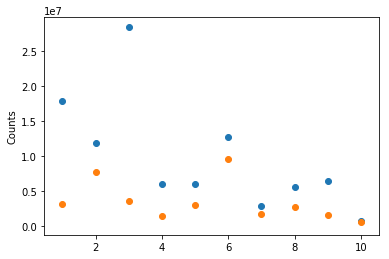

In [50]:
center = aperture_photometry(image, apertures1, method='center')
plt.scatter(result_tab['id'], result_tab['flux_fit'])
plt.scatter(result_tab['id'], center['aperture_sum'])
plt.ylabel('Counts');

The counts from the different methods seem different in the plot shown above, because the way the counts are chosen are different.  
For the PSF fitting, the table gives out a value of the maximum count of the star that it fitted.  
But for the aperture photometry, the counts are an average count, so it shows a more constant value.  
Also, I could not find out how to compare the results of the same star, so that could also be the reason the two results differ.